
Processing Pair 1...
Best Hyperparameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Model Accuracy on Test Set: 0.9567
Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       275
           1       0.93      0.52      0.67        25

    accuracy                           0.96       300
   macro avg       0.94      0.76      0.82       300
weighted avg       0.96      0.96      0.95       300


Processing Pair 2...
Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Model Accuracy on Test Set: 0.9267
Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       260
           1       0.75      0.68      0.71        40

    accuracy                           0.93       300
   mac

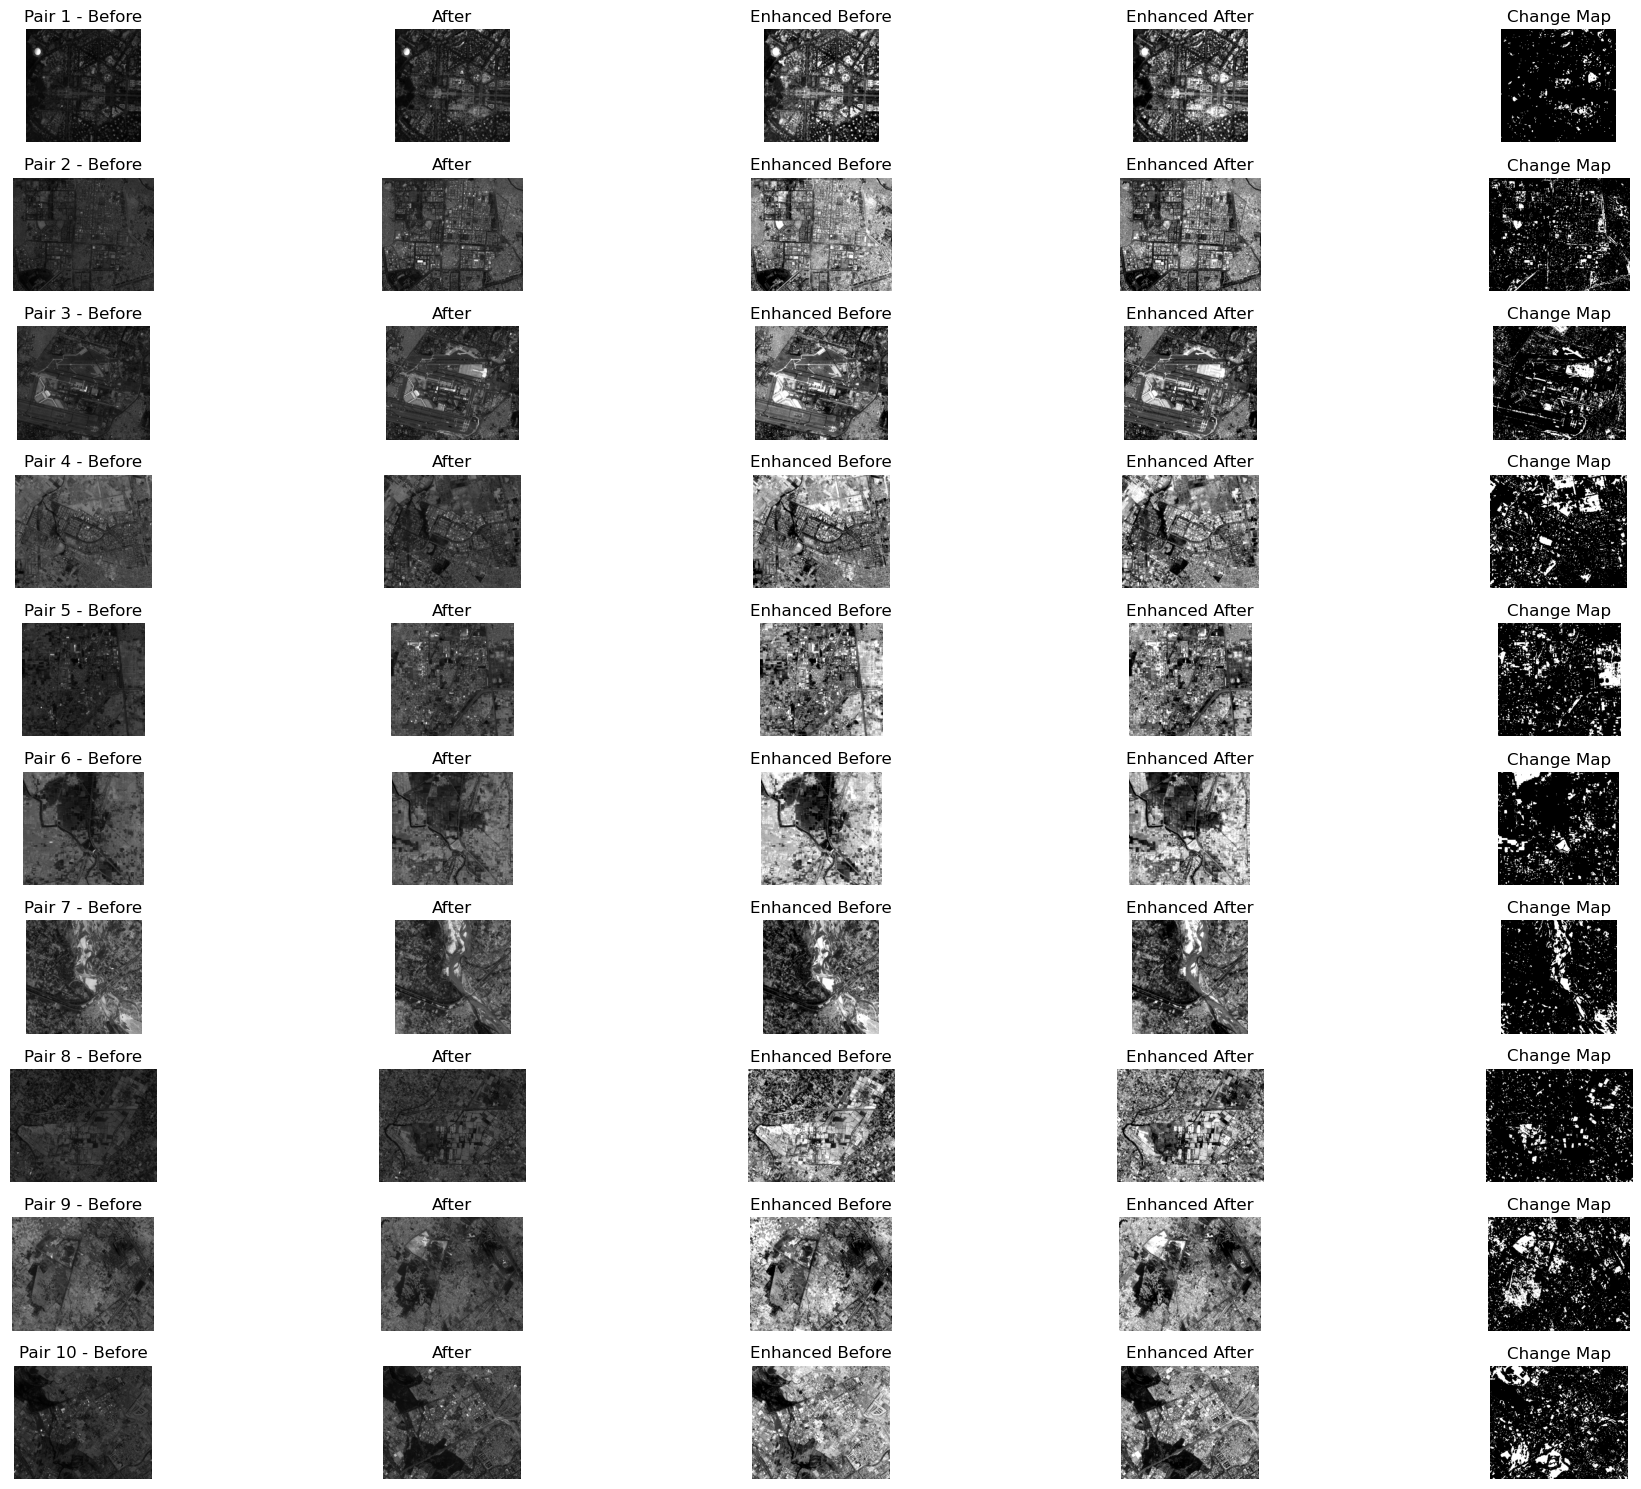

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

def load_images(image1_path, image2_path):
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)
    if img1.shape != img2.shape:
        raise ValueError("Images must have the same shape")
    img1 = img1.astype(float) / 255.0
    img2 = img2.astype(float) / 255.0
    return img1, img2

def extract_features(img1, img2, window_size=5):
    features = []
    h, w = img1.shape
    half_window = window_size // 2
    coords = []

    img1_padded = np.pad(img1, ((half_window, half_window), (half_window, half_window)), mode='constant')
    img2_padded = np.pad(img2, ((half_window, half_window), (half_window, half_window)), mode='constant')
    for i in range(h):
        for j in range(w):
            window1 = img1_padded[i:i + window_size, j:j + window_size]
            window2 = img2_padded[i:i + window_size, j:j + window_size]
            diff_intensity = abs(img1[i, j] - img2[i, j])

            mean1 = np.mean(window1)
            mean2 = np.mean(window2)
            std1 = np.std(window1)
            std2 = np.std(window2)

            diff_mean = abs(mean1 - mean2)
            diff_std = abs(std1 - std2)

            feature_vector = [diff_intensity, diff_mean, diff_std]
            features.append(feature_vector)
            coords.append((i, j))
    return np.array(features), coords

def simulate_ground_truth(img1, img2, n_samples=1000, threshold=0.1):
    h, w = img1.shape
    labels = []
    sampled_features = []
    np.random.seed(42)
    all_features, _ = extract_features(img1, img2)
    indices = np.random.choice(h * w, n_samples, replace=False)
    for idx in indices:
        feat = all_features[idx]
        diff_intensity = feat[0]
        label = 1 if diff_intensity > threshold + np.random.normal(0, 0.02) else 0
        labels.append(label)
        sampled_features.append(feat)
    return np.array(sampled_features), np.array(labels)

def train_random_forest(features, labels):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, stratify=labels)

    param_grid = {
        'n_estimators': [50,100, 200],
        'max_depth': [3,5, 10, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 3],
        'max_features': ['sqrt', 'log2']
    }

    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_rf = grid_search.best_estimator_
    y_pred = best_rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Best Hyperparameters:", grid_search.best_params_)
    print(f"Model Accuracy on Test Set: {accuracy:.4f}")
    print("Classification Report on Test Set:\n", classification_report(y_test, y_pred))
    return best_rf

def predict_change_map(rf, features, coords, h, w):
    predictions = rf.predict(features)
    change_map = np.zeros((h, w), dtype=np.uint8)
    for (i, j), pred in zip(coords, predictions):
        change_map[i, j] = 255 if pred == 1 else 0
    return change_map

def linear_stretch(image):
    """
    Apply linear contrast stretching to enhance grayscale image.
    """
    in_min = np.percentile(image, 2)
    in_max = np.percentile(image, 98)
    stretched = (image - in_min) / (in_max - in_min)
    stretched = np.clip(stretched, 0, 1)
    return stretched

# Image paths (replace with your actual file paths)
image_pairs = [
    ('2016/2016.tif', '2025/2025.tif'),
    ('2016/d4_2016.tif', '2025/d4_2025.tif'),
    ('2016/a5_2016.tif', '2025/a5_2025.tif'),
    ('2016/d1_2016.tif', '2025/d1_2025.tif'),
    ('2016/d2_2016.tif', '2025/d2_2025.tif'),
    ('2016/d5_2016.tif', '2025/d5_2025.tif'),
    ('2016/d7_2016.tif', '2025/d7_2025.tif'),
    ('2016/d8_2016.tif', '2025/d8_2025.tif'),
    ('2016/d9_2016.tif', '2025/d9_2025.tif'),
     ('2016/e1_2016.tif', '2025/e1_2025.tif'),
    
]

plt.figure(figsize=(20, 15))

for idx, (image1_path, image2_path) in enumerate(image_pairs):
    print(f"\nProcessing Pair {idx+1}...")

    img1, img2 = load_images(image1_path, image2_path)
    h, w = img1.shape
    features, coords = extract_features(img1, img2)
    train_features, train_labels = simulate_ground_truth(img1, img2, n_samples=1000)
    rf = train_random_forest(train_features, train_labels)
    change_map = predict_change_map(rf, features, coords, h, w)

    enhanced1 = linear_stretch(img1)
    enhanced2 = linear_stretch(img2)

    # Visualization
    plt.subplot(len(image_pairs), 5, idx * 5 + 1)
    plt.imshow(img1, cmap='gray')
    plt.title(f'Pair {idx+1} - Before')
    plt.axis('off')

    plt.subplot(len(image_pairs), 5, idx * 5 + 2)
    plt.imshow(img2, cmap='gray')
    plt.title('After')
    plt.axis('off')

    plt.subplot(len(image_pairs), 5, idx * 5 + 3)
    plt.imshow(enhanced1, cmap='gray')
    plt.title('Enhanced Before')
    plt.axis('off')

    plt.subplot(len(image_pairs), 5, idx * 5 + 4)
    plt.imshow(enhanced2, cmap='gray')
    plt.title('Enhanced After')
    plt.axis('off')

    plt.subplot(len(image_pairs), 5, idx * 5 + 5)
    plt.imshow(change_map, cmap='gray')
    plt.title('Change Map')
    plt.axis('off')

plt.tight_layout()
plt.show()